<a href="https://colab.research.google.com/github/AkseliManninen/A-Star-Search-Algorithm-Visualized/blob/main/Efficient_and_Scalable_Bayesian_Neural_Nets_with_Rank_1_Factors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Efficient and Scalable Bayesian Neural Nets with Rank-1 Factors


https://arxiv.org/abs/2005.07186

# Importing and installing libraries

In [1]:
# Installing libraries
!pip install einops
!pip install tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.5 MB/s eta 0:00:00


In [136]:
# Importing libraries
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.distributions as D
import matplotlib.pyplot as plt
from einops import rearrange
from IPython import display
import math
import numpy as np
from tqdm import tqdm, trange
from tensorboardX import SummaryWriter
writer = SummaryWriter()
import time

# Configuration

In [3]:
# Select the device for training (use GPU if you have one)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
  print("Using a GPU")
else:
  print("Using a CPU")

Using a GPU


In [4]:
# Changing the working directory
from google.colab import drive
drive.mount('/content/drive')

# Path to the "Tutkimusprojekti" folder in the root of Google Drive
google_drive_path = '/content/drive/My Drive/Opinnot/Tutkimusprojekti'

# Change the current directory to the "Tutkimusprojekti" folder
os.chdir(google_drive_path)

# Check the current working directory to verify the change
data_dir = os.getcwd()
print("Current working directory:", data_dir)

Mounted at /content/drive
Current working directory: /content/drive/My Drive/Opinnot/Tutkimusprojekti


# Data


In [137]:
# Define batch sizes
TRAIN_BATCH_SIZE = 100
TEST_BATCH_SIZE = 10

# Data transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the pixel values
])

# Load training dataset
train_set = torchvision.datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True)

# Load test dataset
test_set = torchvision.datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=TEST_BATCH_SIZE, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


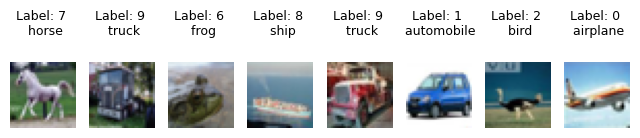

In [138]:
# Define function for showing images and labels
def show_cifar_images(images, labels, class_names, figsize=(8, 8)):
    n_col = len(images)
    fig, axes = plt.subplots(1, n_col, figsize=figsize)

    for i, ax in enumerate(axes.flat):
        ax.axis('off')
        if i < n_col:
            ax.axis('off')
            label = labels[i].item()
            image = (images[i].permute(1, 2, 0).cpu().numpy() + 1) / 2
            ax.imshow(image)
            title = f'Label: {label} \n {class_names[label]}'
            ax.set_title(title, pad=20, fontsize=9)

    plt.show()

# Define a list of class names for CIFAR-10
cifar10_class_names = ["airplane", "automobile", "bird", "cat", "deer",
                      "dog", "frog", "horse", "ship", "truck"]

# Displaying CIFAR-10 training images and labels
images, labels = next(iter(train_loader))
show_cifar_images(images[:8], labels[:8], cifar10_class_names)

# Model: Bayesian Neural Nets with Rank-1 Factors






## Gaussian class

The Gaussian class represents a stochastic variable following a Gaussian (normal) distribution. The distribution has a mean $\mu$ (mu) and a standard deviation $\rho$ (rho). Sigma $\sigma$ is used in sampling from the Gaussian distribution and it is parameterised as $\sigma = log(1+exp(\rho))$.
<br>
<br>

### Sampling
In sampling, first epsilon is calculated as $\epsilon$ ~ N(0, I).
Then a posterior sample of the weights **w** is calculated as **w** = $\mu + \sigma  \circ \epsilon$.
<br>
<br>

### Log probability
The log probability (log_prob) function is used for calculating the log probability of weights under the Gaussian distribution. This can be achieved using the probability density function (PDF) of the Gaussian distribution.

$log(p(w_j)))$ = $log(\frac{1}{\sqrt{2\pi\sigma}})-\frac{(w_j-\pi)^2}{2\sigma^2}$

<br>

Source: C. Blundell et. all. 2015. Weight Uncertainty in Neural Networks. https://arxiv.org/pdf/1505.05424.pdf

In [139]:
class Gaussian(object):
    def __init__(self, mu, rho):
        super().__init__()
        """
        Create a Gaussian distribution with mean (mu) and log standard deviation (rho).

        Args:
            mu (torch.Tensor):  The mean of the Gaussian distribution.
            rho (torch.Tensor): The log of the standard deviation of the Gaussian distribution.
        """

        self.mu = mu
        self.rho = rho
        self.normal = D.Normal(0,1)

    # Calculate the standard deviation sigma
    @property
    def sigma(self):
        return torch.log1p(torch.exp(self.rho))

    # Generate and return samples from the Gaussian distribution
    def sample(self):
        epsilon = self.normal.sample(self.rho.size()).to(DEVICE)
        return self.mu + self.sigma * epsilon

    # Calculate the log probability of the input under the Gaussian distribution
    def log_prob(self, input):
        return (-torch.log(torch.sqrt(torch.tensor(2) * torch.pi))
                - torch.log(self.sigma)
                - ((input - self.mu) ** 2) / (2 * self.sigma ** 2)).sum()

## Scale mixture prior

Gaussian-scale mixtures are typical hierarchical priors for Bayesian Neural Networks. In this implementation, a combination of two Gaussian densities are used as the prior. The mean of these densities are zero and their variances are different.
<br>

### Log probability

To calculate the probability of weights under the prior scale mixture prior, the following formula is used:

$p(\textbf{w})= \Pi_{j} \pi N(w_j |0,\sigma^2_1)+(1-\pi)N(w_j |\sigma^2_2)$,

where $\pi = \frac{1}{2}$, $\sigma_1 = 1$ and $\sigma_2 = 0.0025$.

The log probability (log_prob) function utilizes the Gaussian class' function log_prob.

Source: C. Blundell et. all. 2015. Weight Uncertainty in Neural Networks. https://arxiv.org/pdf/1505.05424.pdf

In [140]:
class ScaleMixtureGaussian(object):
    def __init__(self, mus, sigmas, pi=0.5):
        super().__init__()
        """
        Create a Gaussian-scale mixture prior.

        Args:
            pi     (float):
            mus    (array): An array of means of the normal distributions.
            sigmas (array): An array of variances of the normal distributions.
        """

        self.pi = pi # 1 x 1
        self.k = len(sigmas)
        self.sigmas = torch.tensor(sigmas)[..., None].to(DEVICE) # 1 x k
        self.mus = torch.tensor(mus)[..., None].to(DEVICE) # 1 x k

        self.gaussians = torch.distributions.Normal(self.mus, self.sigmas)

    # Calculate the log probability of the weights under the scale mixture prior distribution
    def log_prob(self, input):

        log_probs = self.gaussians.log_prob(input) + torch.log(torch.tensor(self.pi)) # k x input
        log_probs_logsumexp = torch.logsumexp(log_probs, dim=0) # 1 x input
        log_probs_sum = log_probs_logsumexp.sum() - torch.log(torch.tensor(self.k)) # 1 x 1

        return log_probs_sum

## Bayesian Rank-1 convolution

$W' = W ◦ rs^T$

### Kullback–Leibler (KL) divergence

In [141]:
class BayesianConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding="same"):
        """
        Args:
          Create a Bayesian convolution

          in_channels (int):  Number of input channels.
          out_channels (int): Number of output channels.
          kernel_size (int):  Controls kernel size (kernel_size x kernel_size).
          stride (int):       Controls the stride.
          padding (int):      Controls the padding.
        """
        super(BayesianConv2d, self).__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Initializing the learnable random variables r and s
        self.r_mu = nn.Parameter(torch.Tensor(in_channels).uniform_(-0.2, 0.2))
        self.r_rho = nn.Parameter(torch.Tensor(in_channels).uniform_(-5, -4))
        self.r = Gaussian(self.r_mu, self.r_rho)

        self.s_mu = nn.Parameter(torch.Tensor(out_channels).uniform_(-0.2, 0.2))
        self.s_rho = nn.Parameter(torch.Tensor(out_channels).uniform_(-5, -4))
        self.s = Gaussian(self.s_mu, self.s_rho)

        # Prior distributions
        SIGMA_1 = torch.cuda.FloatTensor([math.exp(-0)]) # 1.
        SIGMA_2 = torch.cuda.FloatTensor([math.exp(-6)]) # 0.0025
        SIGMAS = [SIGMA_1, SIGMA_2]
        MUS = torch.ones(2)

        self.r_prior = ScaleMixtureGaussian(mus = MUS, sigmas = SIGMAS)
        self.s_prior = ScaleMixtureGaussian(mus = MUS, sigmas = SIGMAS)

        # Convolutional layer
        self.conv = torch.nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, padding = self.padding)

    def forward(self, input, sample=False, calculate_log_probs=False):
        """
        Args:
          input: (torch tensor) input image batch of size batch_size x in_channels x height x width
        """

        # Sample from r and s
        r_samples = self.r.sample().to(DEVICE) # shape: 1 x in_channels
        s_samples = self.s.sample().to(DEVICE) # shape: 1 x out_channels

        inputs_times_r_samples = input * r_samples[..., None, None] # shape: batch_size x in_channels x heigth x width

        conv_out = self.conv(inputs_times_r_samples) # shape: batch_size, out_channels, height, width

        out = conv_out * s_samples[..., None, None] # shape: batch_size, out_channels, height, width

        return out

    def kl_divergence(self):
      kl_div = 0.0  # Initialize the total KL divergence

      # KL divergence for r
      kl_div += self.r.log_prob(self.r.sample()) - self.r_prior.log_prob(self.r.sample())

      # KL divergence for s
      kl_div += self.s.log_prob(self.s.sample()) - self.s_prior.log_prob(self.s.sample())

      return kl_div

In [148]:
TRAIN_EPOCHS = 10

class BayesianWideResNet(nn.Module):
    def __init__(self):
        super(BayesianWideResNet, self).__init__()

        # 3x3 conv 1
        self.conv1 = BayesianConv2d(3, 96, kernel_size=3).to(DEVICE)
        self.bn1 = nn.BatchNorm2d(96)

        # 3x3 conv 2
        self.conv2 = BayesianConv2d(96, 96, kernel_size=3).to(DEVICE)
        self.bn2 = nn.BatchNorm2d(96)

        # 3x3 conv 3
        self.conv3 = BayesianConv2d(96, 192, kernel_size=3).to(DEVICE)
        self.bn3 = nn.BatchNorm2d(192)

        # 3x3 conv 4
        self.conv4 = BayesianConv2d(192, 192, kernel_size=3).to(DEVICE)
        self.bn4 = nn.BatchNorm2d(192)

        # 3x3 conv 5
        self.conv5 = BayesianConv2d(192, 192, kernel_size=3).to(DEVICE)
        self.bn5 = nn.BatchNorm2d(192)

        # 1x1 conv 6
        self.conv6 = BayesianConv2d(192, 192, kernel_size=1).to(DEVICE)
        self.bn6 = nn.BatchNorm2d(192)

        # 1x1 conv 7
        self.conv7 = BayesianConv2d(192, 10, kernel_size=1).to(DEVICE)
        self.bn7 = nn.BatchNorm2d(10)

    def forward(self, x):
        # 3x3 conv 1
        x = F.relu(self.bn1(self.conv1(x)))

        # 3x3 conv 2
        x = F.relu(self.bn2(self.conv2(x)))

        # 3x3 max-pooling stride 2
        x = F.max_pool2d(x, 3, stride=2)

        # 3x3 conv 3
        x = F.relu(self.bn3(self.conv3(x)))

        # 3x3 conv 4
        x = F.relu(self.bn4(self.conv4(x)))

        # 3x3 max-pooling stride 2
        x = F.max_pool2d(x, 3, stride=2)

        # 3x3 conv 5
        x = F.relu(self.bn5(self.conv5(x)))

        # 1x1 conv 6
        x = F.relu(self.bn6(self.conv6(x)))

        # 1x1 conv 7
        x = self.bn7(self.conv7(x))

        # Global averaging over 6 × 6 spatial dimensions
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = x.view(x.size(0), -1)

        # 10-way softmax
        x = F.log_softmax(x, dim=1)

        return x

# Create and train the Bayesian network
def train_bayesian_model():

    # Initialize the model, optimizer, and loss function
    model = BayesianWideResNet().to(DEVICE)

    # Separate weight and bias parameters from others for weight decay
    weight_decay_params = []  # For convolutional layers
    other_params = []  # For batch normalization

    for name, param in model.named_parameters():
        if 'bias' or 'weight' in name:
            weight_decay_params.append(param)
        else:
            other_params.append(param)

    optimizer = optim.SGD([
        {'params': weight_decay_params, 'weight_decay': 1e-4},  # Apply weight decay to weights
        {'params': other_params, 'weight_decay': 0},  # Exclude weight decay for batch normalization
    ], lr=0.05)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(TRAIN_EPOCHS):
        model.train()
        for i, data in enumerate(train_loader):
          images, labels = next(iter(train_loader))
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)
          optimizer.zero_grad()
          outputs = model(images)
          data_likelihood = criterion(outputs, labels)
          kl_loss = 0
          flag = 0
          for layer in model.modules():
            if isinstance(layer, BayesianConv2d):
              kl_loss += layer.kl_divergence()
              if flag == 0:
                flag = 1
          loss = data_likelihood + kl_loss / len(train_loader.dataset)
          loss.backward()
          optimizer.step()
        print(f'Epoch [{epoch+1}/{TRAIN_EPOCHS}], Loss: {loss.item()}')
    return model

# Test the Bayesian model
def test_bayesian_model():
    test_images, test_labels = next(iter(train_loader))
    test_images = test_images.to(DEVICE)
    test_labels = test_labels.to(DEVICE)

    # Load the trained Bayesian model
    model = BayesianWideResNet().to(DEVICE)
    model.load_state_dict(torch.load('bayesian_model.pth', map_location=DEVICE))
    model.eval()

    with torch.no_grad():
        outputs = model(test_images)
        predicted = torch.argmax(outputs, dim=1)
        print("Predicted labels:", predicted)
        print("Correct lables:", test_labels)

        # Calculate and print the loss
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, test_labels)
        print("Test Loss:", loss.item())

if __name__ == "__main__":
    start_time = time.time()
    print("Training started at:", time.ctime())
    model = train_bayesian_model()
    end_time = time.time()
    print("Training ended at:", time.ctime())
    print("Training took", end_time - start_time, "seconds")
    torch.save(model.state_dict(), 'bayesian_model.pth')
    test_bayesian_model()

Training started at: Mon Nov  6 10:28:05 2023


<ipython-input-140-8c1a05394654>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mus = torch.tensor(mus)[..., None].to(DEVICE) # 1 x k


Epoch [1/10], Loss: 1.2392830848693848
Epoch [2/10], Loss: 0.9859887361526489
Epoch [3/10], Loss: 0.7316992878913879
Epoch [4/10], Loss: 0.7111186981201172
Epoch [5/10], Loss: 0.657351016998291
Epoch [6/10], Loss: 0.6584974527359009
Epoch [7/10], Loss: 0.4637945592403412
Epoch [8/10], Loss: 0.5772182941436768
Epoch [9/10], Loss: 0.4740980565547943
Epoch [10/10], Loss: 0.42897915840148926
Training ended at: Mon Nov  6 10:36:29 2023
Training took 504.1186442375183 seconds
Predicted labels: tensor([5, 8, 9, 0, 0, 6, 2, 9, 2, 8, 9, 1, 9, 0, 6, 1, 8, 9, 9, 6, 8, 9, 1, 2,
        9, 3, 8, 0, 0, 1, 0, 6, 0, 6, 1, 8, 9, 9, 2, 6, 1, 9, 0, 2, 9, 6, 9, 4,
        3, 3, 9, 8, 7, 5, 9, 2, 2, 2, 8, 9, 1, 1, 1, 9, 8, 7, 5, 8, 0, 2, 9, 9,
        1, 2, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 1, 9, 2, 8, 8, 1, 2, 8, 9, 9, 7,
        7, 0, 1, 7], device='cuda:0')
Correct lables: tensor([5, 8, 1, 0, 0, 6, 6, 5, 2, 8, 0, 1, 7, 0, 6, 1, 8, 7, 3, 6, 8, 5, 1, 2,
        9, 3, 8, 0, 0, 1, 0, 6, 0, 6, 1, 8, 7, 3, 2, 

# Evaluation

- Accuracy
- Negative log likelihood
- Calibration error

Correct labels tensor([3, 8, 8, 0, 6, 6, 1, 6])


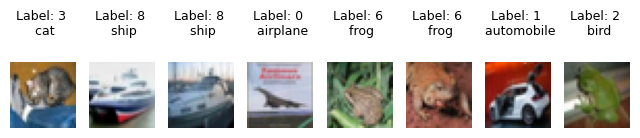

In [149]:
# Compare predicted labels to correct labels

images, labels = next(iter(test_loader))
with torch.no_grad():
    images = images.to(DEVICE)
    predicted_labels = model(images).argmax(dim=1).cpu().numpy()

print("Correct labels", labels[:8])
show_cifar_images(images[:8], predicted_labels[:8], cifar10_class_names)

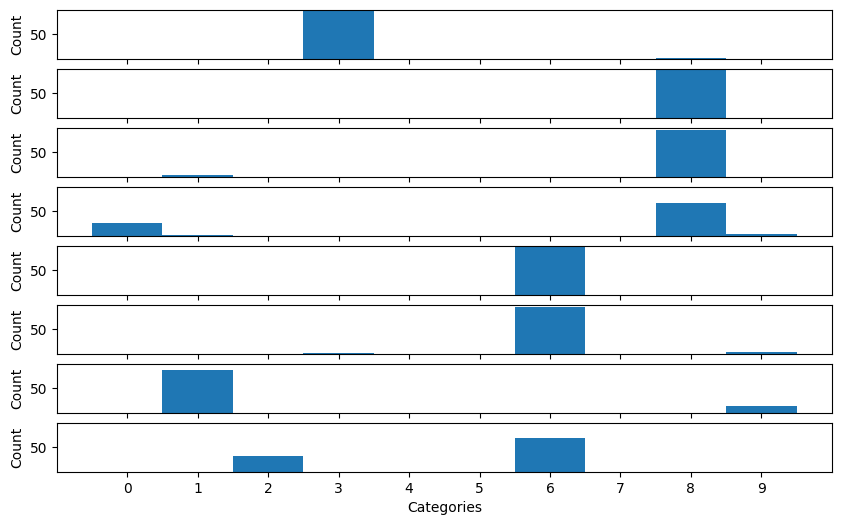

In [150]:
model.eval()

num_additional_predictions = 99

cifar_outputs = model(images).max(1, keepdim=True)[1].detach().cpu().numpy()

for _ in range(num_additional_predictions):
    batch_predictions = model(images).max(1, keepdim=True)[1].detach().cpu().numpy()
    cifar_outputs = np.append(cifar_outputs, batch_predictions, axis=1)

plt.subplots(8, 1, figsize=(10, 6))

for i in range(8):
    plt.subplot(8, 1, i+1)
    plt.ylim(0, num_additional_predictions + 1)
    plt.xlabel("Categories")
    plt.xticks(range(10), ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"])
    plt.ylabel("Count")
    plt.yticks(range(50, num_additional_predictions + 1, 50))
    plt.hist(cifar_outputs[i], np.arange(-0.5, 10, 1))

plt.show()

In [155]:
CLASSES = 10
TEST_SAMPLES = 5
TEST_SIZE = len(test_loader.dataset)

def test_ensemble():
    model.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES+1, dtype=int)

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES+1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = model(images)[:, :10]
            outputs[TEST_SAMPLES] = model(images)[:, :10]
            output = outputs.mean(0)
            preds = preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1] # index of max log-probability
            corrects += preds.eq(labels.view_as(pred)).sum(dim=1).squeeze().cpu().numpy() # squeeze the tensor, move it to CPU, and convert to a NumPy array
            correct += pred.eq(labels.view_as(pred)).sum().item()

    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))

test_ensemble()

Component 0 Accuracy: 7160/10000
Component 1 Accuracy: 7144/10000
Component 2 Accuracy: 7188/10000
Component 3 Accuracy: 7128/10000
Component 4 Accuracy: 7164/10000
Posterior Mean Accuracy: 7201/10000
Ensemble Accuracy: 7557/10000


In [154]:
def test_ensemble():
    model.eval()
    correct = 0
    corrects = np.zeros(TEST_SAMPLES + 1, dtype=int)
    confidences = []
    predictions = []
    nll = 0.0
    ece = 0.0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            outputs = torch.zeros(TEST_SAMPLES + 1, TEST_BATCH_SIZE, CLASSES).to(DEVICE)
            for i in range(TEST_SAMPLES):
                outputs[i] = model(data)[:, :10]
            outputs[TEST_SAMPLES] = model(data)[:, :10]
            output = outputs.mean(0)
            preds = outputs.max(2, keepdim=True)[1]
            pred = output.max(1, keepdim=True)[1]

            # Calculate NLL
            #log_probs = F.log_softmax(outputs, dim=2)
            #nll += -log_probs.gather(2, target.view(target.size(0), 1, 1)).squeeze().sum().item()

            # Calculate ECE
            confidence = F.softmax(outputs, dim=2).max(2)[0]  # Max confidence per prediction
            correct_indicator = preds.eq(target.view_as(pred)).squeeze()
            binned_confidence = torch.histc(confidence[correct_indicator], bins=10, min=0.0, max=1.0)
            binned_accuracy = torch.histc(confidence[correct_indicator], bins=10, min=0.0, max=1.0,
                                          weights=correct_indicator[correct_indicator])
            bin_sizes = binned_confidence + 1e-10
            accuracy_in_bins = binned_accuracy / bin_sizes
            confidences.extend(confidence[correct_indicator].tolist())
            predictions.extend(correct_indicator.tolist())

    #nll /= TEST_SIZE
    confidences = np.array(confidences)
    predictions = np.array(predictions)
    accuracy_in_bins = accuracy_in_bins.numpy()

    # Calculate ECE
    ece = np.abs(accuracy_in_bins - confidences).mean()

    for index, num in enumerate(corrects):
        if index < TEST_SAMPLES:
            print('Component {} Accuracy: {}/{}'.format(index, num, TEST_SIZE))
        else:
            print('Posterior Mean Accuracy: {}/{}'.format(num, TEST_SIZE))
    print('Ensemble Accuracy: {}/{}'.format(correct, TEST_SIZE))
    #print('NLL: {:.4f}'.format(nll))
    print('ECE: {:.4f}'.format(ece))

test_ensemble()

TypeError: ignored